Добро пожаловать в отбор на спецсеминар Тинькофф х Мехмат 23/24. Внимательно читайте задания и не забывайте отвечать на вопросы. Ваши текстовые ответы влияют на оценивание так же, как и корректность и качество кода.

Небольшая подсказка. Не нужно писать функции с нуля. Если вы знаете, в какой библиотеке реализована нужная вам функциональность, обязательно импортируйте ее😉

Успехов!

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('./mm_sem_2023.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   f1          5000 non-null   float64
 1   f2          5000 non-null   float64
 2   f3          5000 non-null   float64
 3   f4          5000 non-null   float64
 4   f5          5000 non-null   float64
 5   target      5000 non-null   int64  
 6   quarter_dt  5000 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 273.6+ KB


In [24]:
# В дополнение, сразу преобразуем даты в кварталы, для следующих заданий

df['quarter_dt'] = pd.to_datetime(df['quarter_dt'])
df['quarter'] = df['quarter_dt'].dt.to_period('Q')
df['quarter'] = df['quarter'].dt.quarter
df.drop('quarter_dt', axis=1, inplace=True)

# Задание 0. Загрузка данных и разведочный анализ.

Скачайте датасет `mm_sem_2023.csv` по [ссылке](https://data.tinkoff.ru/s/MfSgi5rfNEJGPgF). Пароль: **`x3S*b@J**

В датасете есть признаки `f1`-`f5`, целевая переменная `target`, а также временная метка каждого наблюдения `quarter_dt`. Загрузите датасет в ноутбук, выполните разведочный анализ и ответьте на вопросы:

1. Расчитайте статистики признаков и таргета (среднее, медиана, стандартное отклонение, минимум, максимум). *Для чего нужно смотреть на эти статистики? Какие проблемы в данных можно так обнаружить?*

In [25]:
df.agg(['mean', 'median', 'std', 'min', 'max'])

,f1,f2,f3,f4,f5,target,quarter
mean,-0.509316,-0.527417,0.045004,0.273515,-0.004194,0.501400,2.518800
median,-0.626253,-0.570927,0.051334,0.370586,0.293907,1.000000,3.000000
std,1.224053,1.386525,1.091565,1.550531,1.439814,0.500048,1.111528
min,-4.984914,-4.896355,-3.927267,-5.401335,-5.372376,0.000000,1.000000
max,2.875604,4.355007,3.728363,5.431503,3.561569,1.000000,4.000000


Благодаря данным статистикам можно многое узнать о выборке: 
  
- Разброс между значениями
- Выбросы в данных
- Насколько данные для одного признака отличны друг от друга

Проблемы:
- Выбросы
- Неравномерность распределения
- Асимметрия (если медиана сильно отличается от среднего, работает для числовых признаков)

2. Расчитайте корреляционную матрицу признаков. *Как влияет корреляция в переменных на линейную модель (не важно – регрессия или классификация)?*

In [26]:
df.corr(numeric_only=True)

,f1,f2,f3,f4,f5,target,quarter
f1,1.000000,-0.082772,0.646622,0.465942,-0.290140,-0.393534,-0.004231
f2,-0.082772,1.000000,-0.808929,-0.919560,0.181372,-0.373522,0.015998
f3,0.646622,-0.808929,1.000000,0.968193,-0.226628,0.048707,-0.012858
f4,0.465942,-0.919560,0.968193,1.000000,-0.310044,0.179367,-0.016630
f5,-0.290140,0.181372,-0.226628,-0.310044,1.000000,-0.013205,0.023361
target,-0.393534,-0.373522,0.048707,0.179367,-0.013205,1.000000,0.004092
quarter,-0.004231,0.015998,-0.012858,-0.016630,0.023361,0.004092,1.000000


Корреляция влияет на:
- Стабильность оценок. У f3 и f4 корреляция близка к 1, это может привести к проблемам в оценке коэффициентов модели (модель будет чувствительна к изменениям в данных)
- Точность модели: target слабо коррелирован с признаками, точность линейной модели не будет высокой

# Задание 1. Считаем WoE по бакетам.

Разбейте каждый признак на 5 бакетов по квантилям (первый бакет – от 0 до 0.2 квантиля, второй – от 0.2 до 0.4 и т.д.).

Для наблюдений, попавших в каждый бакет, расчитайте weight of evidence, $WoE$, по формуле:

$$WoE_i = \ln \frac{B_i}{G_i} - \ln \frac{B}{G}$$

Где $B_i$ – количество наблюдений с $y=1$ в бакете $i$ ($B$ – количество единиц по всей выборке). Аналогично $G_i$ – количество наблюдений с $y = 0$ в бакете $i$.

Для каждого признака расчитайте $WoE$ по бакетам и нарисуйте график (ось Х – номер бакета, ось Y – значение WoE). Сделайте вывод об информативности каждой переменной.

In [27]:
def calc_woe_by_bucket(x: pd.Series, y: pd.Series) -> pd.Series:
    
    """
    Разбивает признак на 5 бакетов по квантилям. В каждом бакете
    считает WoE. Возвращает массив с WoE длины 5.
    """
    
    bins = np.quantile(x, q=np.linspace(0,1,min(6, x.nunique())))
    x_binned = pd.cut(x, bins=bins, labels=False, include_lowest=True)
    B = y.sum()
    G = y.size - B
    grouped = x_binned.groupby(x_binned)
    B_i = grouped.agg(lambda x: y[x.index].sum())
    G_i = grouped.size() - B_i
    woe_i = np.log(B_i / G_i / B * G)
    return woe_i

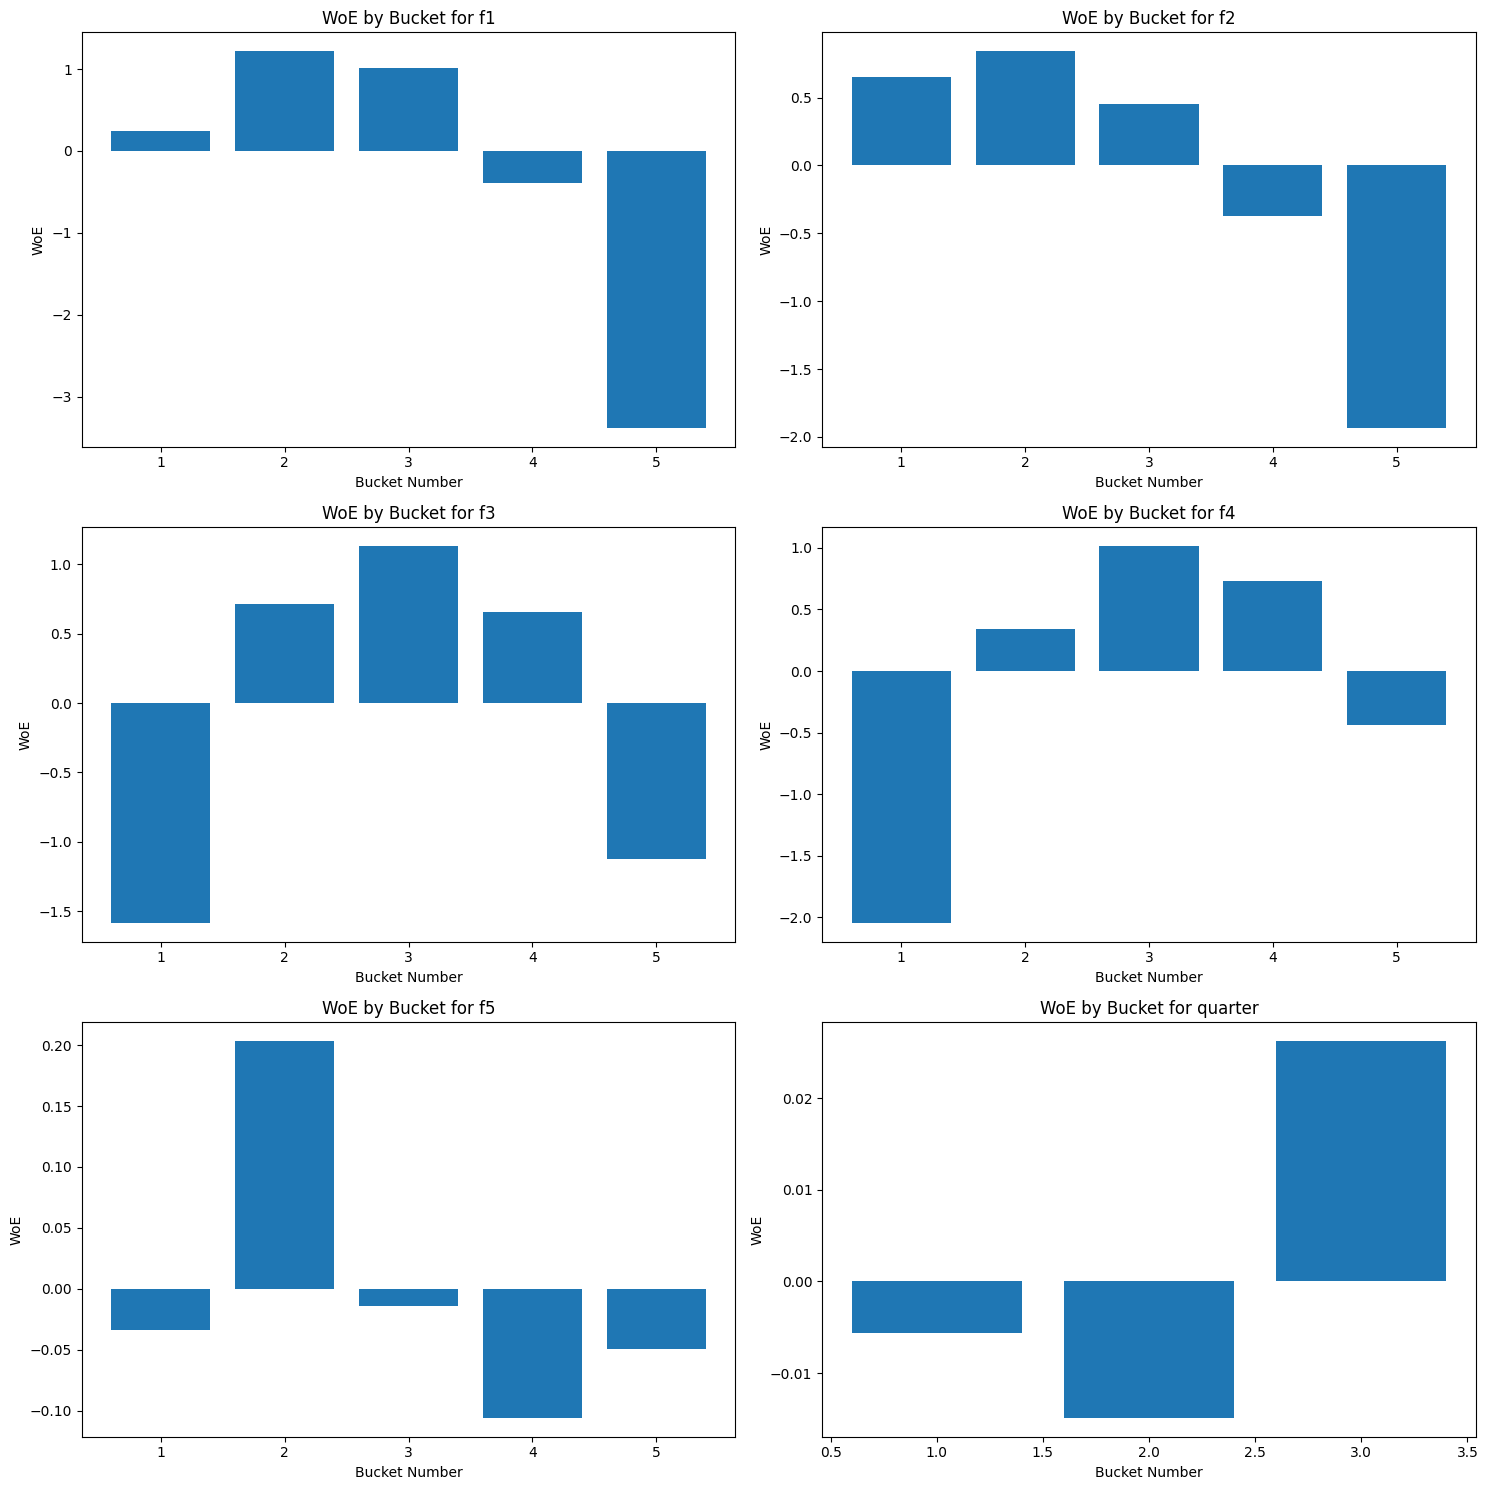

In [28]:
plt.figure(figsize=(15, 15))

for i, feature in enumerate(df.columns[df.columns != 'target'], 1):
    woe = calc_woe_by_bucket(df[feature], df['target'])
    plt.subplot(3, 2, i)
    plt.bar(range(1, woe.shape[0]+1), woe)
    plt.title(f'WoE by Bucket for {feature}')
    plt.xlabel('Bucket Number')
    plt.ylabel('WoE')

plt.tight_layout()
plt.show()

Выводы из графиков:

- Признаки с 1 по 4 указывают на потенциально высокое значимость для модели.

- Признак f5 - менее значим.

- Признак quarter не сбалансирован

# Задание 2. Доверительный интервал для WoE.

Модифицируйте функцию `calc_woe_by_bucket`. Добавьте в нее расчет 68%-доверительного интервала для WoE с помощью бутстрапа. Константу $\ln \frac{B}{G}$ при расчете считайте фиксированной. Постройте новый график WoE по бакетам с доверительными интервалами (ось Х – номер бакета, ось Y – значение WoE + доверительный интервал для него).

Для каких переменных можно изменить вывод об информативности, посмотрев на доверительные интервалы?

In [37]:
from typing import Tuple

def calc_woe_by_bucket_ci(x: pd.Series, y: pd.Series) -> Tuple[pd.Series]:
   """Разбивает признак на 5 бакетов по квантилям. В каждом бакете
   считает WoE и доверительные интервалы. Возвращает три массива длины 5:
    - woe в бакете
    - верхняя граница дов. интервала
    - нижняя граница дов. интервала
   """
   bootstrapped_woes = []
   B = y.sum()
   G = y.size - B
   C = np.log(B / G)

   for _ in range(1000):
       indices = np.random.choice(x.index, size=len(x), replace=True)
       sample_x = x.loc[indices]
       sample_y = y.loc[indices]

       # Расчет WoE для подвыборки
       bins = np.quantile(sample_x, q=np.linspace(0,1,min(6, x.nunique())))
       x_binned = pd.cut(sample_x, bins=bins, labels=False, include_lowest=True)
       grouped = x_binned.groupby(x_binned)
       B_i = grouped.agg(lambda _sample_x: sample_y[_sample_x.index].sum())
       G_i = grouped.size() - B_i
       woe_i = np.log(B_i / G_i) - C
       bootstrapped_woes.extend(woe_i)

   # Расчет 68% доверительного интервала
   lower = np.percentile(bootstrapped_woes, 16)
   upper = np.percentile(bootstrapped_woes, 84)

   return woe, lower, upper

In [ ]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(df.columns[df.columns != 'target'], 1):
    woe, lower, upper = calc_woe_by_bucket_ci(df[feature], df['target'])
    plt.subplot(3, 2, i)
    plt.errorbar(range(len(woe)), woe, yerr=[woe - lower, upper - woe], fmt='o', ecolor='r', capsize=5, label='WoE with CI')
    plt.xlabel('Bucket Number')
    plt.ylabel('WoE Value')
    plt.title(f'WoE by {feature} with 68% Confidence Intervals')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Задание 3. Строим модель.

Разбейте выборку на трейн (1 полугодие 2022) и тест (2 полугодие). Стандартизуйте переменные и обучите логистическую регрессию. Постройте график ROC AUC этой модели поквартально, отделив трейн и тест вертикальной линией (ось Х – квартал, ось Y – значение ROC AUC).

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [32]:
df_final = df.sort_values(by=['quarter'])

y = df_final['target']
X = df_final.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_test, X_test

(            f1        f2        f3        f4        f5  quarter
 3781  0.094346 -1.092801  0.784383  1.080727  0.967875        3
 3780  0.737580  1.157676 -0.445528 -0.697096 -2.033919        3
 3554 -2.678097  1.857464 -2.569672 -3.134750  0.253545        3
 3787 -0.545842  0.694482 -0.835637 -0.876069 -1.684131        3
 3346  1.382350  0.718543  0.204447  0.027174 -1.567220        3
 ...        ...       ...       ...       ...       ...      ...
 3927 -2.794658 -0.007210 -1.465651 -1.372827  0.685477        4
 287   0.603311  2.113303 -0.805860 -1.886832  2.271828        4
 3924 -2.477958 -0.031703 -1.373062 -1.137087 -0.687842        4
 1393 -2.323447  1.988673 -2.426994 -3.111338  0.693515        4
 976  -2.661835  0.430272 -1.630029 -1.758439  1.128692        4
 
 [2500 rows x 6 columns],
             f1        f2        f3        f4        f5  quarter
 3781  0.094346 -1.092801  0.784383  1.080727  0.967875        3
 3780  0.737580  1.157676 -0.445528 -0.697096 -2.033919       

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


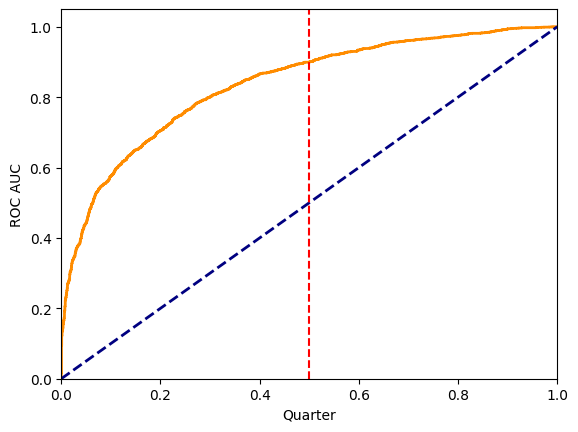

In [34]:
y_score = clf.predict_proba(X)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y, y_score)
roc_auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.plot(X_test['quarter_int'].unique(), quarterly_roc_auc)
plt.axvline(x=X_train.size / (X_train.size + X_test.size), color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Quarter')
plt.ylabel('ROC AUC')
plt.show()

Посмотрите на коэффициенты модели. Какие признаки оказались наименее информативными? Совпадает ли это с выводами на основе WoE?

In [35]:
# Посмотрим коэффициенты классификатора
clf.coef_

array([[-1.38796383, -0.97622245, -0.10791917,  0.33428917, -0.18963165,
        -0.01191634]])

Первый коэффициент выглядит наиболее значимым, последний - наименее, как и в предыдущих пунках. Проверим t-тестом на значимость коэффициентов для множественной регрессии:

In [36]:
from scipy import stats

for i in range(clf.coef_.size):
  
  '''
  Построим гипотезу для каждого коэффициента и протестируем t-тестом
  
  H_0: переменная coef не влияет на y (coef == 0)
  H_1: coef != 0
  '''
  
  coef = clf.coef_[0][i]
  _col = df_final.iloc[:, i]
  t_stat, p_val = stats.ttest_1samp(_col.to_numpy(), coef)
  print("For coef by index =", i, "t-statistic:", t_stat, "p-value:", p_val)


For coef by index = 0 t-statistic: 50.757458657987414 p-value: 0.0
For coef by index = 1 t-statistic: 22.88841458087349 p-value: 2.391544663454158e-110
For coef by index = 2 t-statistic: 9.906243142858377 p-value: 6.352197216273506e-23
For coef by index = 3 t-statistic: -2.771560162787373 p-value: 0.005599474254428477
For coef by index = 4 t-statistic: 9.107041315655069 p-value: 1.1994855703857663e-19
For coef by index = 5 t-statistic: 72.58691715277396 p-value: 0.0


Из p-value делаем вывод, что для каждого коэффициента нулевая гипотеза отклоняется и нельзя утверждать, что коэффициенты незначимы, то есть они оказывают влияние на y. 